This script uses LDA to calculate decoding accuracy of neuron populations recorded from different sites. Decoding accuracy is calculated while controlling for number of trials and population size used from each recording. It performs the following steps:

1. Loads relevant data
    - Preprocessed spike times
    - ECoG decoding accuracy
2. Calcualtes decoding accuracy for each recording set under different parameters:
    - Event alignment (peripheral target onset, go cue, movement onset)
    - Number of trials
    - Unit adding
3. Calculates statistics between recordings as a function of ECoG decoding accuracy
4. Plot results and save figures


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aopy
import os
import pandas as pds
from db import dbfunctions as db
from ipywidgets import interactive, widgets
import scipy
import h5py
from tqdm.auto import tqdm 
import seaborn as sn
import sklearn
from sklearn.decomposition import PCA, FactorAnalysis
from itertools import compress
import multiprocessing as mp
import time
import math
from scipy.fft import fft
import glob
from datetime import date

# Set parameters

In [2]:
save_figs = False
base_save_dir = "/media/moor-data/results/Ryan/neuropixel_targeting/"
np_preproc_data_folder = 'np_analysis_preproc_data'
ecog_dec_acc_file_name = 'ecog_decoding_maps/npinsert_ecog_decoding_all'

subject = 'beignet'
align_events = ['TARGET ONSET', 'GO CUE', 'MOVEMENT ONSET']

In [3]:
# Decoding calculation parameters
tbefore = 0.5
tafter = 1
nlda_lags = 1
niter_match = 20
min_trial_prop = .85
ntrial_bin_size = 96

# Visualization parameters
colors = sn.color_palette(n_colors=9)
recording_brain_areas={'M1': [30, 56, 47, 40, 121, 48], 'PM':[11, 9, 18]}
day_colors = ['dodgerblue', 'indigo', 'violet', 'lightblue', 'mediumorchid',
              'purple', 'steelblue', 'dodgerblue', 'lightblue', 'red', 'black'] 

In [4]:
def xval_lda(data, labels, sample_rate, lags=3, nfolds=5, smooth_timeseries=False, smooth_width=50, return_weights=False):
    '''
    ** Needs to be able to handle just one lag **
    
    Args:
        data (ntime, nch, ntrials)
        labels (ntrials)
        sample_rate
        lags (int)
        nfolds (int)
        smooth_timeseries
        smooth_width (int): [ms]
        
    Returns:
        decoding_accuracy()
    '''
    ntime, nch, ntrials = data.shape 
    nlabels = len(np.unique(labels))
    
    if smooth_timeseries:
        smoothed_data = smooth_timeseries_gaus(data, sample_rate, smooth_width)
    else:
        smoothed_data = data
    
    # Perform n-fold xval LDA at each time point 
    decoding_accuracy = np.zeros((ntime-lags, nfolds))*np.nan
    weights = np.zeros((ntime-lags, nlabels, lags*nch, nfolds))*np.nan
    nwind = smoothed_data.shape[0] - lags
    for iwind in range(nwind):
        lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
        end_wind = iwind+lags
        
        # If not cross validated
        if nfolds < 2:
            lda.fit(np.vstack(smoothed_data[iwind:end_wind,:,:]).T - np.mean(np.vstack(smoothed_data[iwind:end_wind,:,:]).T, axis=0), labels)
            decoding_accuracy[iwind] = lda.score(np.vstack(smoothed_data[iwind:end_wind,:,:]).T - np.mean(np.vstack(smoothed_data[iwind:end_wind,:,:]).T, axis=0), labels)
        
        # if cross validated: 
        else:
            kf = sklearn.model_selection.KFold(n_splits=nfolds,shuffle=True,random_state=1)
            for ifold, (train_idx, test_idx) in enumerate(kf.split(np.vstack(smoothed_data[iwind:end_wind,:,:]).T)):
                lda.fit(np.vstack(smoothed_data[iwind:end_wind,:,train_idx]).T - np.mean(np.vstack(smoothed_data[iwind:end_wind,:,train_idx]).T, axis=0), labels[train_idx])


                decoding_accuracy[iwind, ifold] = lda.score(np.vstack(smoothed_data[iwind:end_wind,:,test_idx]).T - np.mean(np.vstack(smoothed_data[iwind:end_wind,:,test_idx]).T, axis=0), labels[test_idx])
                weights[iwind,:,:,ifold] = lda.coef_
            
    if return_weights:
        return decoding_accuracy, weights
    else:
        return decoding_accuracy

def lda_single(data, labels, nfolds):
    '''
    data (ntime, nch, ntrials)
    '''
    kf = sklearn.model_selection.KFold(n_splits=nfolds,shuffle=True,random_state=1)
    lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
    data_out = np.zeros(nfolds)*np.nan 
    for ifold, (train_idx, test_idx) in enumerate(kf.split(np.vstack(data[:,:,:]).T)):            
        lda.fit(np.vstack(data[:,:,train_idx]).T - np.mean(np.vstack(data[:,:,train_idx]).T, axis=0), labels[train_idx])
        data_out[ifold] = lda.score(np.vstack(data[:,:,test_idx]).T - np.mean(np.vstack(data[:,:,test_idx]).T, axis=0), labels[test_idx])
    return data_out

def xval_lda_parallel(data, labels, sample_rate, lags=3, nfolds=5, smooth_timeseries=False, smooth_width=50):
    '''
    ** Needs to be able to handle just one lag **
    
    Args:
        data (ntime, nch, ntrials)
        labels (ntrials)
        sample_rate
        lags (int)
        nfolds (int)
        smooth_timeseries
        smooth_width (int): [ms]
        
    Returns:
        decoding_accuracy()
    '''
    ntime, nch, ntrials = data.shape 
    nlabels = len(np.unique(labels))
    
    if smooth_timeseries:
        smoothed_data = smooth_timeseries_gaus(data, sample_rate, smooth_width)
    else:
        smoothed_data = data
    
    # Perform n-fold xval LDA at each time point 
    decoding_accuracy = np.zeros((ntime-lags, nfolds))*np.nan
    nwind = smoothed_data.shape[0] - lags
    input_data = [smoothed_data[iwind:(iwind+lags),:,:] for iwind in range(nwind)]
    # print(len(input_data), len([labels for ii in range(nwind)]), itertools.repeat(nfolds))
    input_args = zip(input_data, [labels for ii in range(nwind)], itertools.repeat(nfolds))
    decoding_accuracy = lda_single(data, labels, nfolds)
    with Pool() as pool:
        decoding_accuracy = np.array(pool.starmap(lda_single, input_args))
    return decoding_accuracy

# Load relevant data

## Load ECoG decoding accuracy

In [5]:
print(os.path.join(base_save_dir, ecog_dec_acc_file_name))
ecog_dec_acc = aopy.data.base.load_hdf_group(base_save_dir, ecog_dec_acc_file_name)

/media/moor-data/results/Ryan/neuropixel_targeting/ecog_decoding_maps/npinsert_ecog_decoding_all


## Load preprocessed neuropixel data

In [6]:
np_data = {}
start = time.time()
for align_event in align_events:
    np_data[align_event] = aopy.data.base.pkl_read(f"{subject}_{align_event}", os.path.join(base_save_dir, np_preproc_data_folder))
print(f"{np.round((time.time()-start)/60)} min to load preprocessed data")
nrecs = len(np_data[align_event]['spike_align'])
recording_site = np_data[align_event]['recording_site'] # will be the same for all align events

3.0 min to load preprocessed data


In [7]:
# TODO move this to preprocessing
for align_event in align_events:
    np_data[align_event]['target_idx_good'] = []
    for irec in range(nrecs):
        np_data[align_event]['target_idx_good'].append(np_data[align_event]['target_idx'][irec][np_data[align_event]['good_trial_idx'][irec]])

# ntrials_by_target = [[np.sum(target_idx_good[id]==itarget+1) for itarget in range(ntargets)] for id in range(len(dates))]
# unit_total_fr = [[len(spike_times[idate][str(unit_labels[idate][iunit])])/(np.max(spike_times[idate][str(unit_labels[idate][iunit])])-np.min(spike_times[idate][str(unit_labels[idate][iunit])])) for iunit in range(len(unit_labels[idate]))] for idate in range(len(dates))]

In [8]:
implants = ['NPinsert72' if np_data[align_events[0]]['implant'][irec] == 'NP_Insert72' else 'NPinsert137' for irec in range(len(np_data[align_events[0]]['implant']))]

## Identify stable units

In [29]:
qc_results = aopy.data.base.pkl_read(f"{subject}_QCunits", os.path.join(base_save_dir, np_preproc_data_folder))
stable_unit_labels = [qc_results['final_good_unit_labels'][irec] for irec in range(nrecs)]
stable_unit_idx = [qc_results['final_good_unit_idx'][irec] for irec in range(nrecs)]
nstable_unit = np.array([len(qc_results['final_good_unit_idx'][irec]) for irec in range(nrecs)])
neuron_pos = [qc_results['position'][irec] for irec in range(nrecs)]

In [10]:
# Get neurons with consistent firing rate across all trials
print(np_data[align_events[2]].keys())
print(np_data[align_events[2]]['spike_align_raster'][0].shape)

for align_event in align_events:
    np_data[align_event]['trial_fr'] = [np.sum(np_data[align_event]['spike_align_raster'][iday], axis=0)/(np_data[align_events[2]]['tbefore_mc']+np_data[align_events[2]]['tafter_mc']) for iday in range(len(np_data[align_event]['spike_align_raster']))]


dict_keys(['spike_times', 'unit_labels', 'trial_times', 'spike_align', 'spike_align_raster', 'spike_labels', 'ks_labels', 'recording_site', 'target_idx', 'good_trial_idx', 'tbefore_mc', 'tafter_mc', 'spike_bin_width_mc', 'trial_time_axis', 'implant', 'spike_pos', 'mc_entries', 'target_idx_good'])
(150, 600, 108)


## Zscore FR

In [11]:
# Zscore the activity of each neuron across all trials
fr_zscore = {}
for align_event in align_events:
    temp_spike_data = np_data[align_event]['spike_align'] # Shape (ntime, ntrial, nunit)
    fr_zscore[align_event] = {'align_spikes_zscore': []}
    [fr_zscore[align_event]['align_spikes_zscore'].append((temp_spike_data[irec]-np.mean(temp_spike_data[irec], axis=(0,1)))/np.std(temp_spike_data[irec], axis=(0,1))) for irec in range(nrecs)]

/tmp/ipykernel_2267178/3962550587.py:6: RuntimeWarning: invalid value encountered in divide
  [fr_zscore[align_event]['align_spikes_zscore'].append((temp_spike_data[irec]-np.mean(temp_spike_data[irec], axis=(0,1)))/np.std(temp_spike_data[irec], axis=(0,1))) for irec in range(nrecs)]


In [12]:
# Identify stable units for different numbers of trials
stable_unit_idx_nunits_tradd = {}
nstable_unit_idx_nunits_tradd = {}
for align_event in align_events:
    ntrial_adding_bins = np.sum(np_data[align_event]['good_trial_idx'][0])//ntrial_bin_size
    stable_unit_idx_nunits_tradd[align_event] = []
    for itradd_bin in range(1,ntrial_adding_bins+1):
        temp_spike_align_data = [np_data[align_event]['spike_align'][irec][:,:(itradd_bin*ntrial_bin_size),:] for irec in range(nrecs)]
        temp_stable_unit_tradd, _ = get_stable_neuropixel_units_across_recs(temp_spike_align_data,  min_trial_prop)
        stable_unit_idx_nunits_tradd[align_event].append(temp_stable_unit_tradd)

NameError: name 'get_stable_neuropixel_units_across_recs' is not defined

In [ ]:
# Zscore the activity of each neuron across all trials
# Levels: 1. align event, 2. ntrials added, 3. recording number
fr_zscore_tradd = {}
for align_event in align_events:
    fr_zscore_tradd[align_event] = {'align_spikes_zscore': []}
    for itradd_bin in tqdm(range(1,ntrial_adding_bins+1)):
        temp_spike_data = [np_data[align_event]['spike_align'][irec][:,:(itradd_bin*ntrial_bin_size),:] for irec in range(nrecs)] # Shape (ntime, ntrial, nunit)
        fr_zscore_tradd[align_event]['align_spikes_zscore'].append([(temp_spike_data[irec]-np.mean(temp_spike_data[irec], axis=(0,1)))/np.std(temp_spike_data[irec], axis=(0,1)) for irec in range(nrecs)])

# Calculate LDA decoding accuracy

In [13]:
lda_results = {}
for align_event in align_events:
    lda_results[align_event] = {}

## nLag analysis

In [30]:
test_lags = np.arange(1,10)
align_event = align_events[-1]
lda_results['lag_test'] = {'scores': {}, 'weights': {}}

for irec in tqdm(range(nrecs)):
    lda_results['lag_test']['scores'][f"site{irec}"] = []
    lda_results['lag_test']['weights'][f"site{irec}"] = []
    for test_lag in tqdm(test_lags):
        units_to_use = stable_unit_idx[irec]
        score, weights = xval_lda(np.swapaxes(fr_zscore[align_event]['align_spikes_zscore'][irec][:,:,units_to_use], 1,2), np_data[align_event]['target_idx_good'][irec], 1/np_data[align_event]['spike_bin_width_mc'], lags=test_lag, smooth_timeseries=False, return_weights=True)
        max_tidx = np.argmax(np.mean(score, axis=1))
        unit_rank = np.flip(np.argsort((np.sum(np.abs(np.mean(weights, axis=3)[max_tidx,:,:]), axis=0))))
        lda_results['lag_test']['scores'][f"site{irec}"].append(score)
        lda_results['lag_test']['weights'][f"site{irec}"].append(weights)
        # lda_results['dec_unit_weight_rank'].append((np.sum(np.abs(np.mean(weights, axis=3)[max_tidx,:,:]), axis=0))[unit_rank])

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

LinAlgError: SVD did not converge

## All units 

In [15]:
ntest_trials = 600
align_event = align_events[-1]
lda_results['dec_unit_weight_rank'] = []
lda_results['scores'] = []
lda_results['weights'] = []
for irec in tqdm(range(nrecs)):
    units_to_use = stable_unit_idx[irec]
    score, weights = xval_lda(np.swapaxes(fr_zscore[align_event]['align_spikes_zscore'][irec][:,:ntest_trials,units_to_use], 1,2), np_data[align_event]['target_idx_good'][irec], 1/np_data[align_event]['spike_bin_width_mc'], lags=1, smooth_timeseries=False, return_weights=True)
    max_tidx = np.argmax(np.mean(score, axis=1))
    unit_rank = np.flip(np.argsort((np.sum(np.abs(np.mean(weights, axis=3)[max_tidx,:,:]), axis=0))))
    lda_results['scores'].append(score)
    lda_results['weights'].append(weights)
    lda_results['dec_unit_weight_rank'].append((np.sum(np.abs(np.mean(weights, axis=3)[max_tidx,:,:]), axis=0))[unit_rank])

  0%|          | 0/11 [00:00<?, ?it/s]

## Neuron number matched

In [17]:
for align_event in tqdm(align_events):
    ntime = len(np_data[align_event]['trial_time_axis'])
    nunits_to_use = np.min([len(stable_unit_idx[irec]) for irec in range(nrecs)])
    lda_results[align_event]['neural_space'] = []
    for irec in tqdm(range(nrecs)):
        temp_lda_neural = np.zeros((ntime-nlda_lags, niter_match))*np.nan
        for ii in range(niter_match):
            unit_idx_temp = np.random.choice(stable_unit_idx[irec], size=nunits_to_use, replace=False)
            temp_lda_neural[:,ii] = np.mean(xval_lda(np.swapaxes(fr_zscore[align_event]['align_spikes_zscore'][irec][:,:,unit_idx_temp], 1,2), np_data[align_event]['target_idx_good'][irec], 1/np_data[align_event]['spike_bin_width_mc'], lags=nlda_lags, smooth_timeseries=False), axis=1)

        lda_results[align_event]['neural_space'].append(temp_lda_neural)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
# from multiprocessing import Pool
# import itertools

# start = time.time()
# for irec in tqdm(range(nrecs)):
#     with Pool() as pool:
#         for ii in range(niter_match):
#             data_clusters = [np.swapaxes(fr_zscore[align_event]['align_spikes_zscore'][irec][:,:,np.random.choice(stable_unit_idx[irec], size=nunits_to_use, replace=False)], 1,2) for ii in range(niter_match)]

#         input_args = list(zip(data_clusters, [np_data[align_event]['target_idx_good'][irec] for ii in range(niter_match)], itertools.repeat(1/np_data[align_event]['spike_bin_width_mc']), itertools.repeat(nlda_lags)))
#         test_out = np.array(pool.starmap(xval_lda, input_args))

# print(time.time()-start)

## Trial adding

In [ ]:
lda_results_tradd = {}
for align_event in align_events:
    lda_results_tradd[align_event] = {}
    lda_results_tradd[align_event]['neural_space'] = []
    nunits_to_use_tradd = np.min([np.min([len(stable_unit_idx_nunits_tradd[align_event][itradd_bin][irec]) for irec in range(nrecs)]) for itradd_bin in range(ntrial_adding_bins)])
    for itradd_bin in range(ntrial_adding_bins):
        lda_neural_tradd_temp = []

        for irec in tqdm(range(nrecs)):
            temp_lda_neural = np.zeros((ntime-nlda_lags, niter_match))*np.nan
            for ii in range(niter_match):
                unit_idx_temp = np.random.choice(stable_unit_idx_nunits_tradd[align_event][itradd_bin][irec], size=nunits_to_use_tradd, replace=False)
                try:
                    temp_lda_neural[:,ii] = np.mean(xval_lda(np.swapaxes(fr_zscore_tradd[align_event]['align_spikes_zscore'][itradd_bin][irec][:,:,unit_idx_temp], 1,2), np_data[align_event]['target_idx_good'][irec], 1/np_data[align_event]['spike_bin_width_mc'], lags=nlda_lags, smooth_timeseries=False), axis=1)
                except:
                    continue
                    
            lda_neural_tradd_temp.append(temp_lda_neural)
        lda_results_tradd[align_event]['neural_space'].append(lda_neural_tradd_temp)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

## Unit adding

# Calculate linear regression decoding accuracy

In [31]:
def calc_task_rel_dims(neural_data, kin_data, conc_proj_data=False, regularization=None):
    '''
    Calculates the task relevant dimensions by regressing neural activity against kinematic data using least squares.
    If the input neural data is 3D, all trials will be concatenated to calculate the subspace. 
    Calculation is based on the approach used in Sun et al. 2022 https://doi.org/10.1038/s41586-021-04329-x
    
    .. math::
    
        R \\in \\mathbb{R}^{nt \\times nch}
        M \\in \\mathbb{R}^{nt \\times nkin}
        \\beta \\in \\mathbb{R}^{nch \\times nkin}
        R = M\\beta^T
        [\\beta_0 \beta_x \beta_y]^T = (M^T M)^{-1} M^T R

    Args:
        neural_data ((nt, nch) or list of (nt, nch)): Input neural data (:math:`R`) to regress against kinematic activity.
        kin_data ((nt, ndim) or list of (nt, ndim)): Kinematic variables (:math:`M`), commonly position or instantaneous velocity. 'ndims' refers to the number of physical dimensions that define the kinematic data (i.e. X and Y)
        conc_proj_data (bool): If the projected neural data should be concatenated.

    Returns:
        tuple: Tuple containing:
            | **(nch, ndim):** Subspace (:math:`\beta`) that best predicts kinematic variables. Note the first column represents the intercept, then the next dimensions represent the behvaioral variables
            | **((nt, nch) or list of (nt, ndim)):** Neural data projected onto task relevant subspace

    '''

    # If a list of segments from trials, concatenate them into one larget timeseries
    if type(neural_data) == list:
        ntrials = len(neural_data)

        conc_neural_data = np.vstack(neural_data) #(nt, nch)
        ntime = conc_neural_data.shape[0]
        
        # Set input neural data as a float
        conc_neural_data = conc_neural_data.astype(float)

        conc_kin_data = np.zeros((ntime,kin_data[0].shape[1]+1))*np.nan
        conc_kin_data[:,0] = 1
        conc_kin_data[:,1:] = np.vstack(kin_data)

        # Center neural data:
        conc_neural_data -= np.nanmean(conc_neural_data, axis=0)

        # Calculate task relevant subspace 
        # task_subspace = np.linalg.pinv(conc_kin_data.T @ conc_kin_data) @ conc_kin_data.T @ conc_neural_data
        if regularization is None:        
            task_subspace = np.linalg.pinv(conc_neural_data.T @ conc_neural_data) @ conc_neural_data.T @ conc_kin_data
        elif regularization == 'lasso':
            lasso_model = sklearn.linear_model.Lasso(alpha=1, max_iter=10000).fit(conc_neural_data, conc_kin_data)
            task_subspace = (lasso_model.coef_).T
        elif regularization == 'ridge':
            ridge_model = sklearn.linear_model.Ridge(alpha=1, max_iter=10000).fit(conc_neural_data, conc_kin_data)
            task_subspace = (ridge_model.coef_).T
        elif regularization == 'elastic net':
            elasticnet_model = sklearn.linear_model.ElasticNet(alpha=1, max_iter=10000).fit(conc_neural_data, conc_kin_data)
            task_subspace = (elasticnet_model.coef_).T
    
    else:
        # Save original neural data as a list
        neural_data = [neural_data]
        
        # Set input neural data as a float
        neural_data_centered = neural_data[0].astype(float)
        
        # Center neural data:
        neural_data_centered -= np.nanmean(neural_data_centered, axis=0)
        ntime = neural_data_centered.shape[0]
        conc_kin_data = np.zeros((ntime, kin_data.shape[1]+1))*np.nan
        conc_kin_data[:,0] = 1
        conc_kin_data[:,1:] = kin_data
        
        # Calculate task relevant subspace 
        if regularization is None:
            task_subspace = np.linalg.pinv(neural_data_centered.T @ neural_data_centered) @ neural_data_centered.T @ conc_kin_data
        elif regularization == 'lasso':
            lasso_model = sklearn.linear_model.Lasso(alpha=1, max_iter=10000).fit(neural_data_centered, conc_kin_data)
            task_subspace = (lasso_model.coef_).T
        elif regularization == 'ridge':
            ridge_model = sklearn.linear_model.Ridge(alpha=1, max_iter=10000).fit(neural_data_centered, conc_kin_data)
            task_subspace = (ridge_model.coef_).T
        elif regularization == 'elastic net':
            elasticnet_model = sklearn.linear_model.ElasticNet(alpha=1, max_iter=10000).fit(neural_data_centered, conc_kin_data)
            task_subspace = (elasticnet_model.coef_).T
        ntrials = 1
        
    # Project neural data onto task subspace
    projected_data = []
    
    for itrial in range(ntrials):
        projected_data.append(neural_data[itrial] @ task_subspace)

    if conc_proj_data:
        return task_subspace, np.vstack(projected_data)
    else:    
        return task_subspace, projected_data

In [ ]:
lin_reg_results = {}

In [32]:
irec = 0
temp_data = np_data[align_events[-1]]['spike_align'][irec]
temp_kin_data = np_data[align_events[-1]]['
test = calc_task_rel_dims([temp_data[:,itr,:] for itr in range(temp_data.shape[1])], 

(150, 600, 108)


# Calculate statistics

## LDA 

In [18]:
# define ecog decoding accuracy as one variable to make it easier to do further analysis
ecog_dec_acc_rec_site = {}
for align_event in align_events:
    ecog_dec_acc_rec_site[align_event] = [ecog_dec_acc['beignet'][f"{implants[irec]}_interp"][rec_site-1] for irec, rec_site in enumerate(np_data[align_event]['recording_site'])]

In [19]:
# Calculate max decoding accuracy for each alignment
for align_event in align_events:
    lda_results[align_event]['neural_space_max'] = [np.max(np.mean(lda_results[align_event]['neural_space'][irec], axis=1)) for irec in range(nrecs)]

In [20]:
# Fit linear regression to max
M1_rec_idx = np.where(np.in1d(recording_site, recording_brain_areas['M1']))[0]
PM_rec_idx = np.where(np.in1d(recording_site, recording_brain_areas['PM']))[0]
for align_event in align_events:
    _, _, lda_results[align_event]['neural_max_pcc'], lda_results[align_event]['neural_max_pcc_pval'], lda_results[align_event]['neural_max_reg_fit'] = aopy.analysis.base.linear_fit_analysis2D(100*np.array(ecog_dec_acc_rec_site[align_event]), 100*np.array(lda_results[align_event]['neural_space_max']))
    _, _, lda_results[align_event]['neural_max_pcc_M1'], lda_results[align_event]['neural_max_pcc_pval_M1'], lda_results[align_event]['neural_max_reg_fit_M1'] = aopy.analysis.base.linear_fit_analysis2D(100*np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx], 100*np.array(lda_results[align_event]['neural_space_max'])[M1_rec_idx])
    _, _, lda_results[align_event]['neural_max_pcc_PM'], lda_results[align_event]['neural_max_pcc_pval_PM'], lda_results[align_event]['neural_max_reg_fit_PM'] = aopy.analysis.base.linear_fit_analysis2D(100*np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx], 100*np.array(lda_results[align_event]['neural_space_max'])[PM_rec_idx])


In [26]:
# Trial adding
# Calculate max decoding accuracy for each alignment
for align_event in align_events:
    lda_results_tradd[align_event]['neural_space_max'] = np.zeros((nrecs, ntrial_adding_bins))*np.nan
    for itradd_bin in range(ntrial_adding_bins):
        lda_results_tradd[align_event]['neural_space_max'][:,itradd_bin] = [np.max(np.mean(lda_results_tradd[align_event]['neural_space'][itradd_bin][irec], axis=1)) for irec in range(nrecs)]

NameError: name 'lda_results_tradd' is not defined

In [104]:
# Trial adding
for align_event in align_events:
    lda_results_tradd[align_event]['neural_max_pcc'] = []
    lda_results_tradd[align_event]['neural_max_pcc_pval'] = []
    lda_results_tradd[align_event]['neural_max_reg_fit'] = []
    lda_results_tradd[align_event]['neural_max_pcc_M1'] = []
    lda_results_tradd[align_event]['neural_max_pcc_pval_M1'] = []
    lda_results_tradd[align_event]['neural_max_reg_fit_M1'] = []
    lda_results_tradd[align_event]['neural_max_pcc_PM'] = []
    lda_results_tradd[align_event]['neural_max_pcc_pval_PM'] = []
    lda_results_tradd[align_event]['neural_max_reg_fit_PM'] = []
    for itradd_bin in range(ntrial_adding_bins):
        _, _, temp1, temp2, temp3 = aopy.analysis.base.linear_fit_analysis2D(100*np.array(ecog_dec_acc_rec_site[align_event]), 100*np.array(lda_results_tradd[align_event]['neural_space_max'][:,itradd_bin]))
        _, _, temp1_M1, temp2_M1, temp3_M1 = aopy.analysis.base.linear_fit_analysis2D(100*np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx], 100*np.array(lda_results_tradd[align_event]['neural_space_max'][:,itradd_bin])[M1_rec_idx])
        _, _, temp1_PM, temp2_PM, temp3_PM = aopy.analysis.base.linear_fit_analysis2D(100*np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx], 100*np.array(lda_results_tradd[align_event]['neural_space_max'][:,itradd_bin])[PM_rec_idx])
        lda_results_tradd[align_event]['neural_max_pcc'].append(temp1)
        lda_results_tradd[align_event]['neural_max_pcc_pval'].append(temp2)
        lda_results_tradd[align_event]['neural_max_reg_fit'].append(temp3)
        lda_results_tradd[align_event]['neural_max_pcc_M1'].append(temp1_M1)
        lda_results_tradd[align_event]['neural_max_pcc_pval_M1'].append(temp2_M1)
        lda_results_tradd[align_event]['neural_max_reg_fit_M1'].append(temp3_M1)
        lda_results_tradd[align_event]['neural_max_pcc_PM'].append(temp1_PM)
        lda_results_tradd[align_event]['neural_max_pcc_pval_PM'].append(temp2_PM)
        lda_results_tradd[align_event]['neural_max_reg_fit_PM'].append(temp3_PM)

## Linear regression

# Plot results and save

## LDA

### nLag analysis

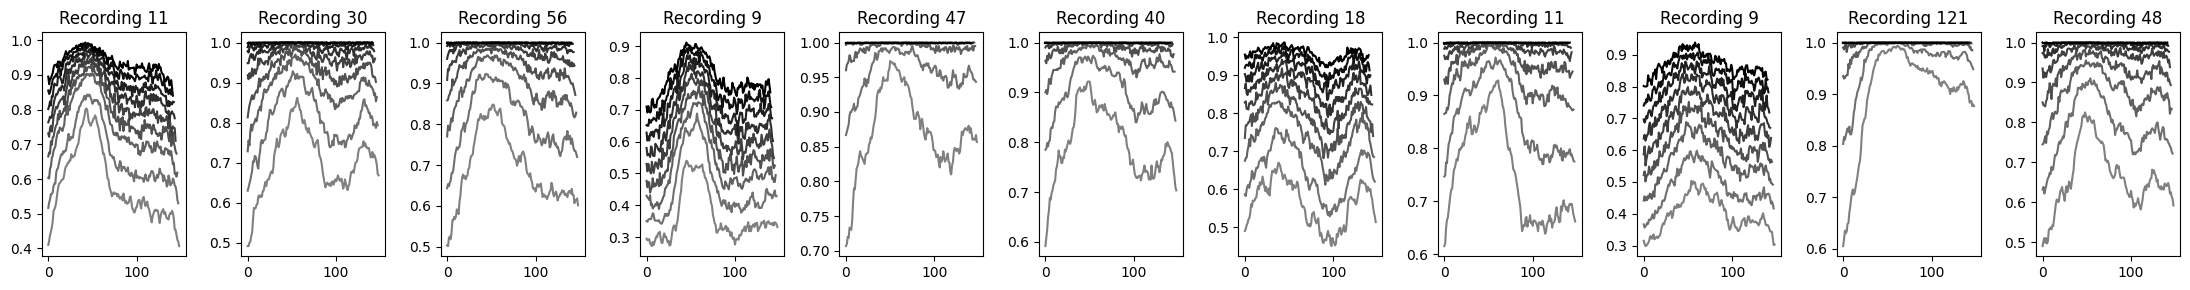

In [21]:
fig, ax = plt.subplots(1,nrecs,figsize=(nrecs*2,3))
for irec in range(nrecs):
    grad = aopy.visualization.get_color_gradient_RGB(len(test_lags), [0,0,0], [0.5,0.5,0.5])
    [ax[irec].plot(np.mean(lda_results['lag_test']['scores'][f"site{irec}"][ilag], axis=1), color=grad[ilag], label=str(ilag)) for ilag in range(len(lda_results['lag_test']['scores'][f"site{irec}"]))]
    # ax[irec].legend()
    ax[irec].set_title(f"Recording {recording_site[irec]}")
fig.tight_layout()
plt.show()

### All units

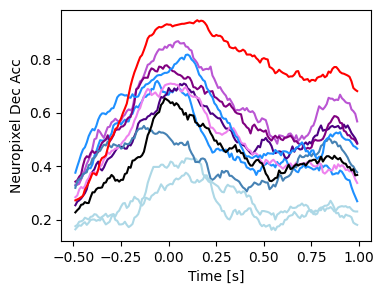

In [22]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
[ax.plot(np_data[align_event]['trial_time_axis'][nlda_lags:], np.mean(lda_results['scores'][irec], axis=1), color=day_colors[irec]) for irec in range(nrecs)]
ax.set(xlabel='Time [s]', ylabel='Neuropixel Dec Acc')
plt.show()

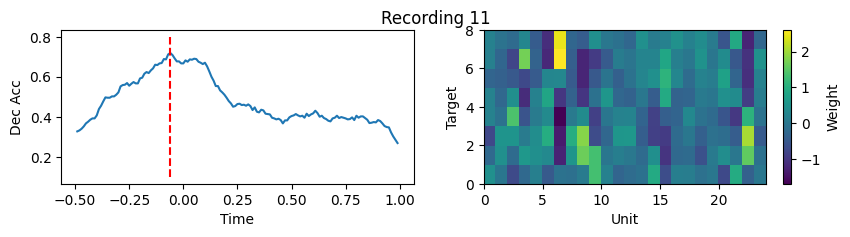

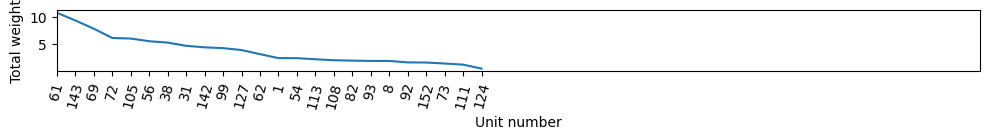

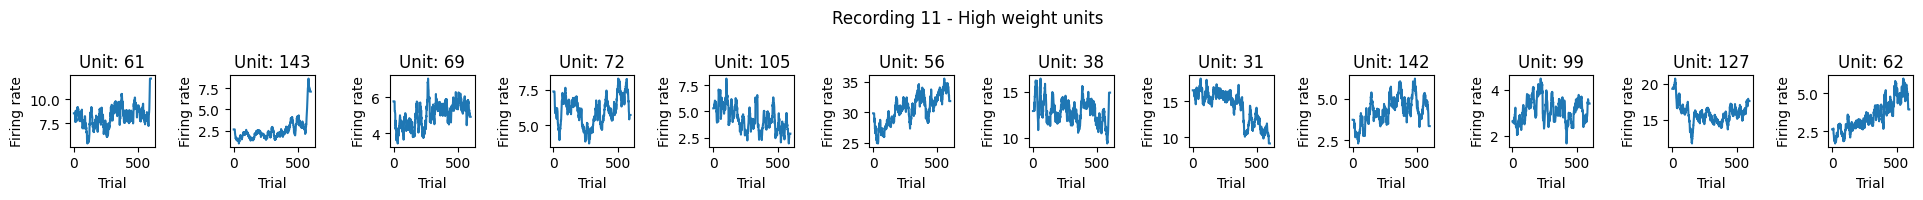

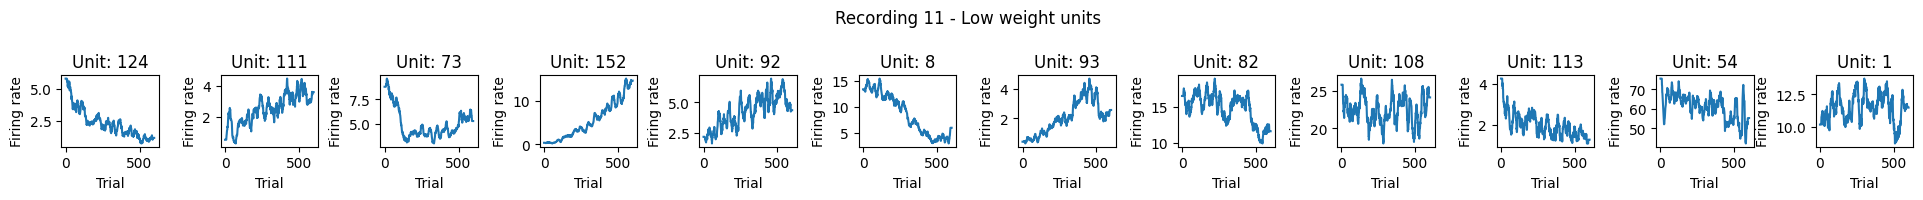

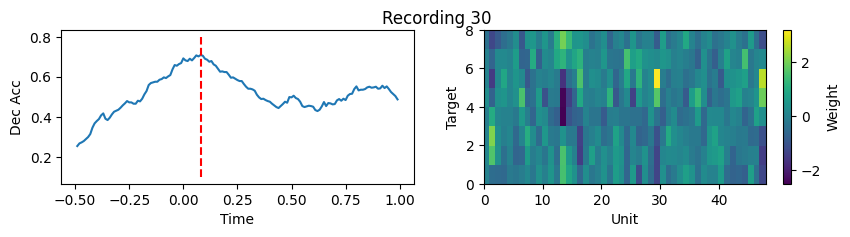

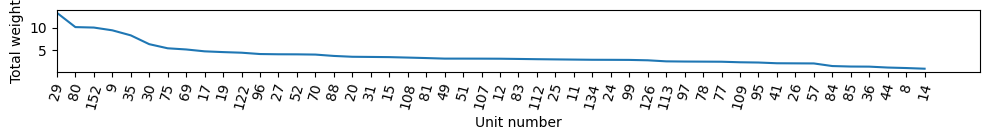

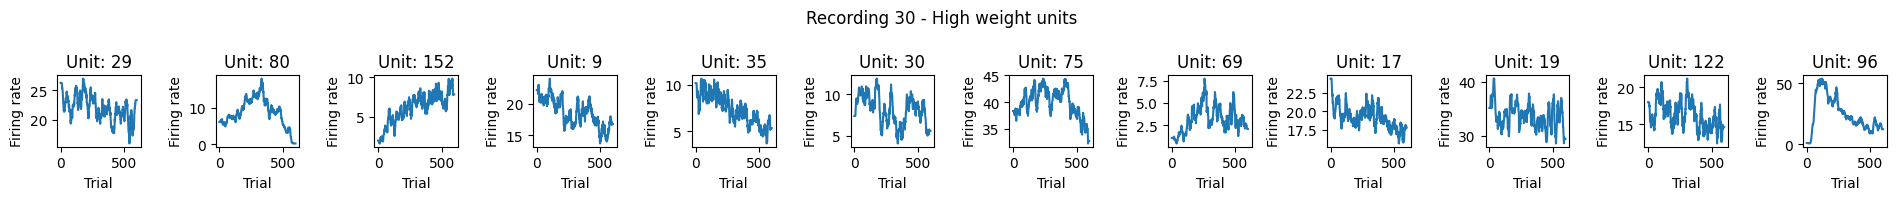

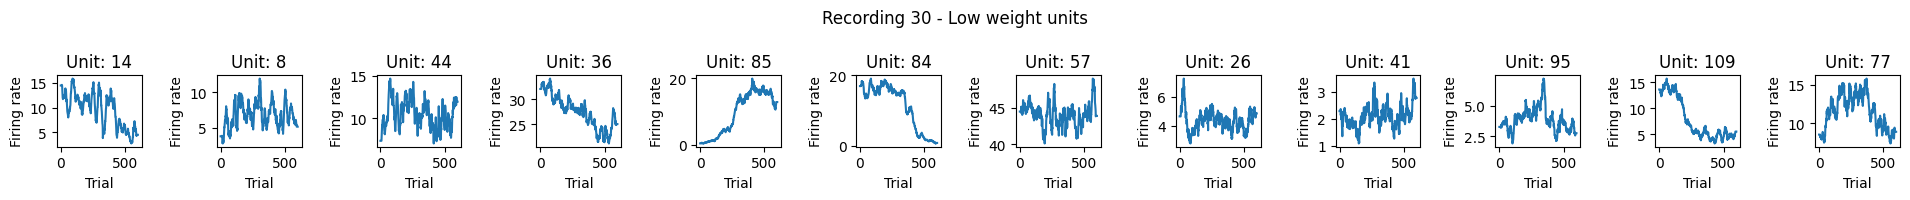

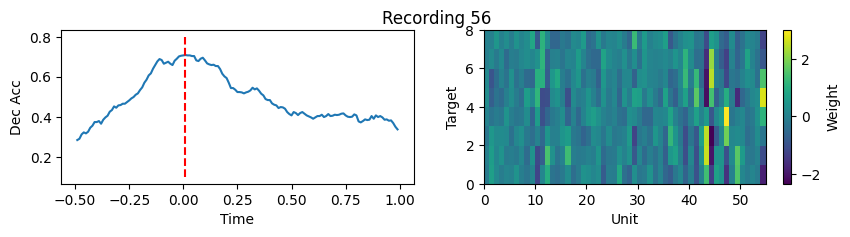

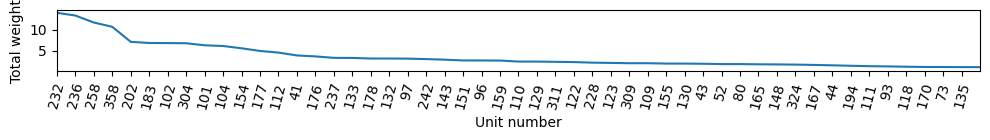

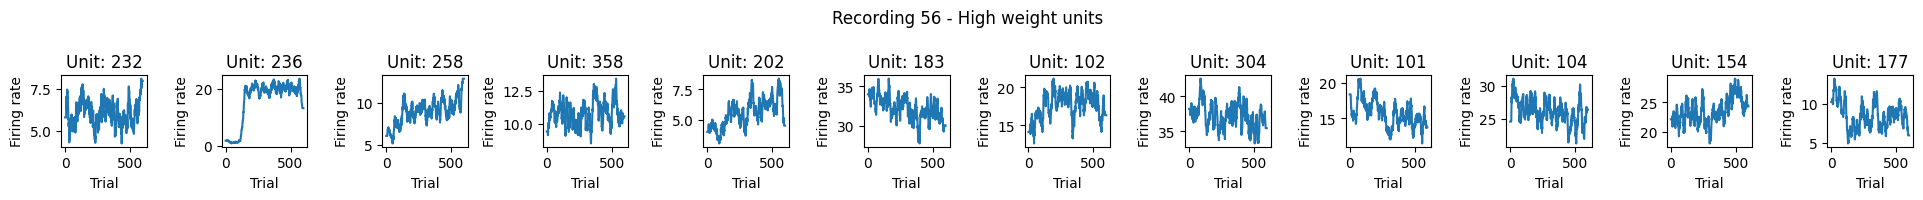

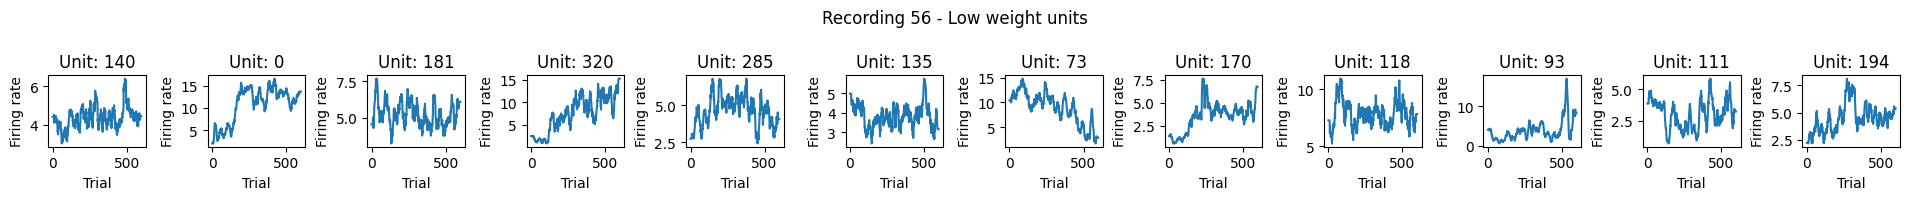

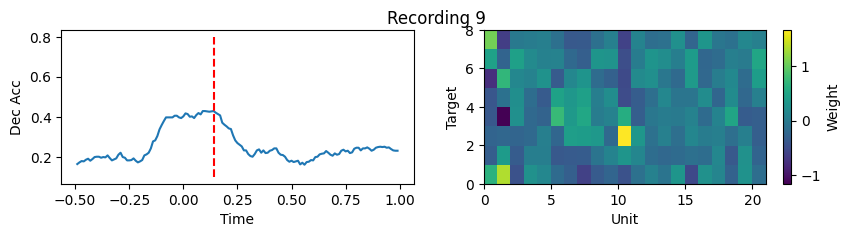

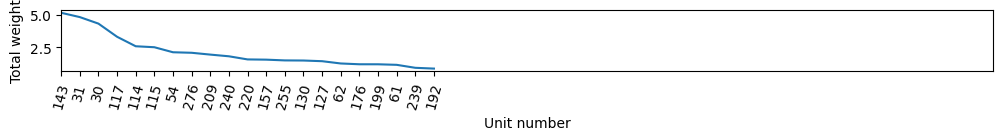

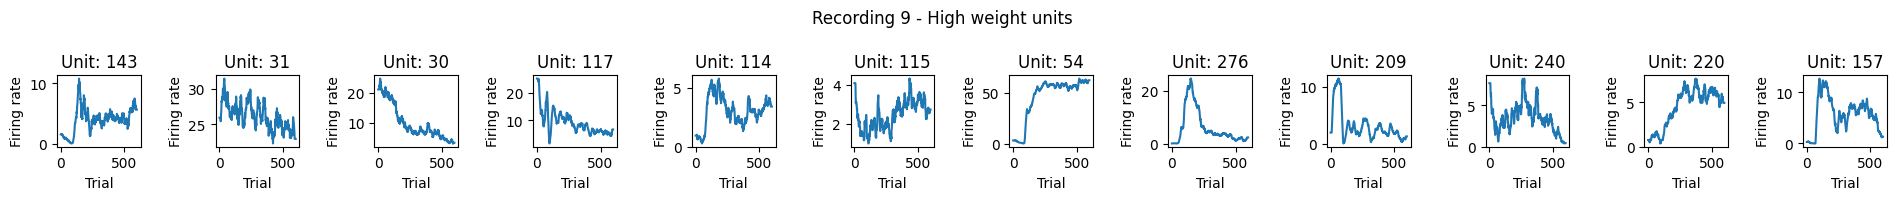

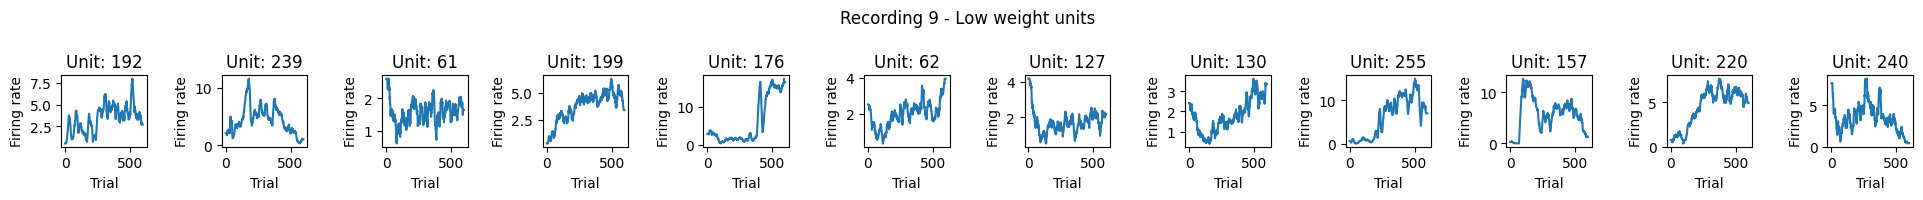

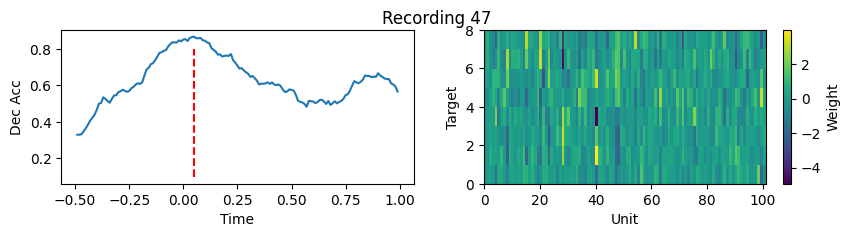

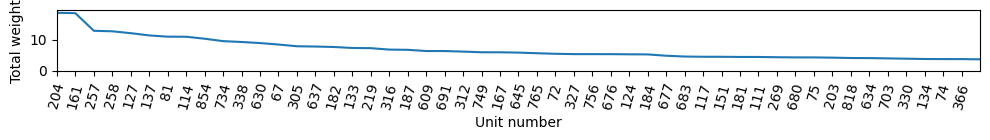

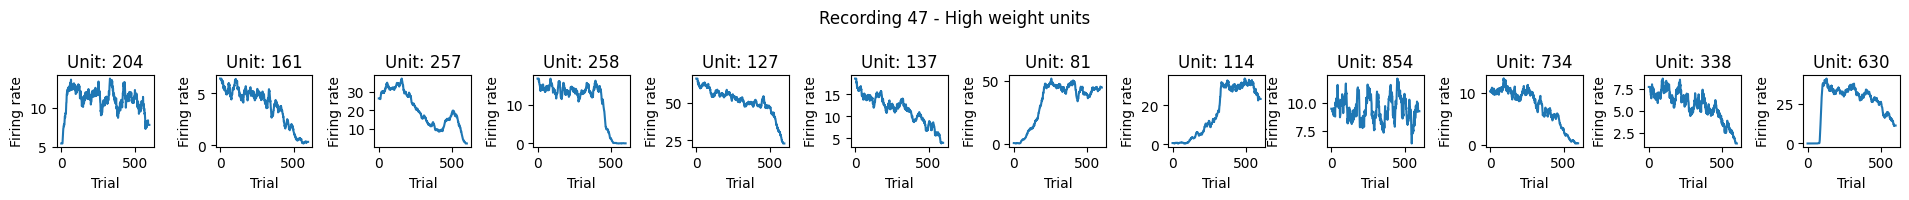

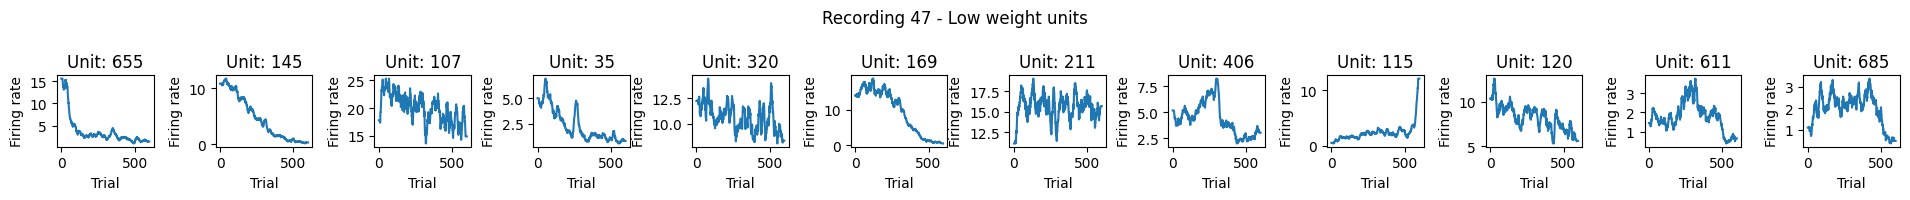

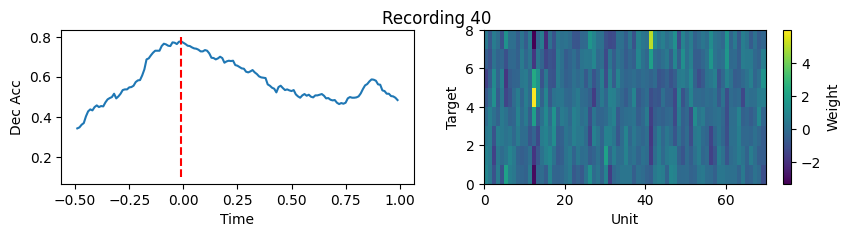

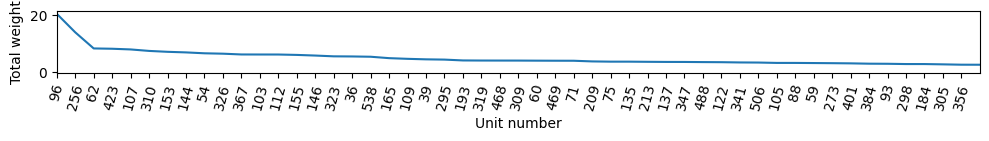

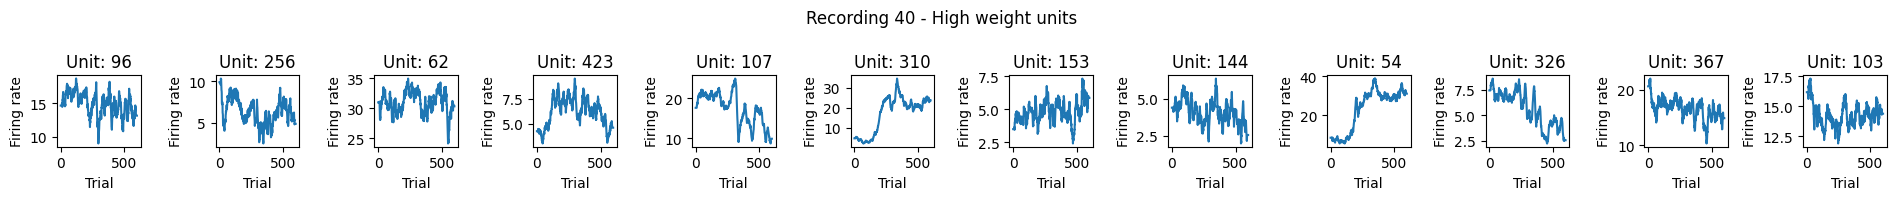

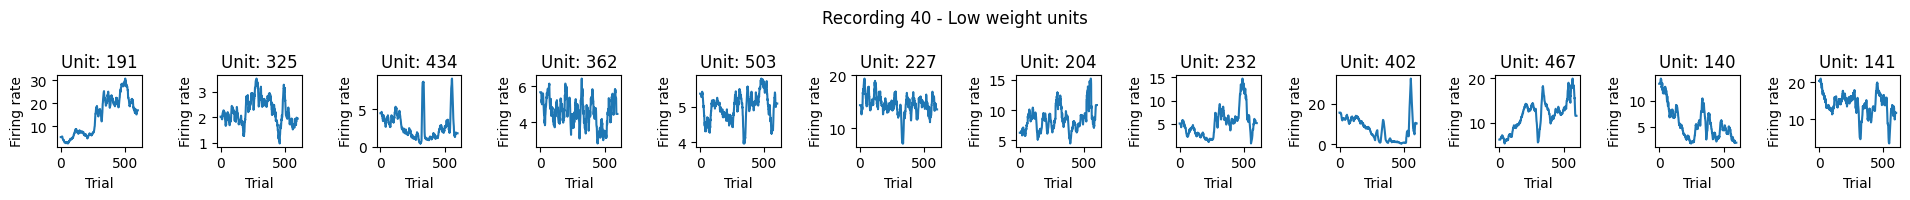

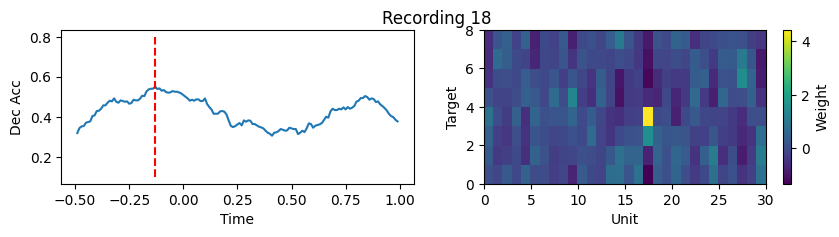

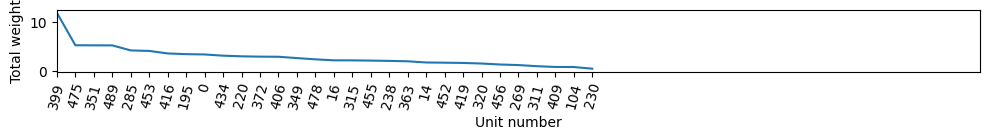

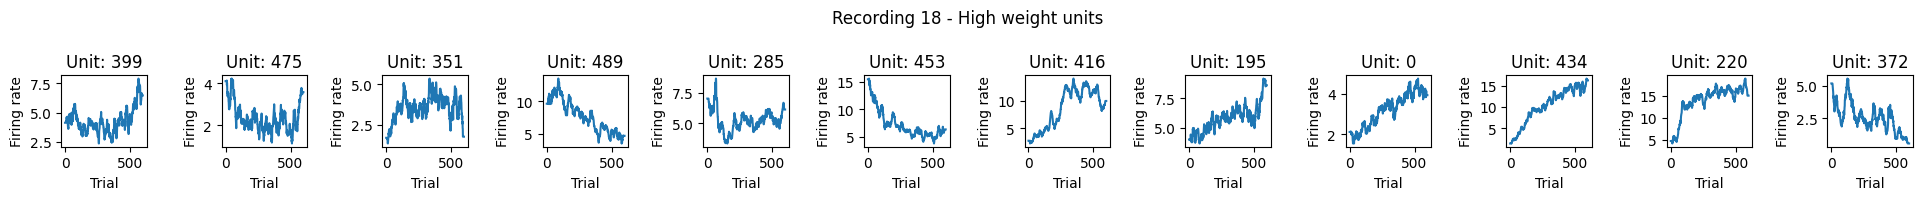

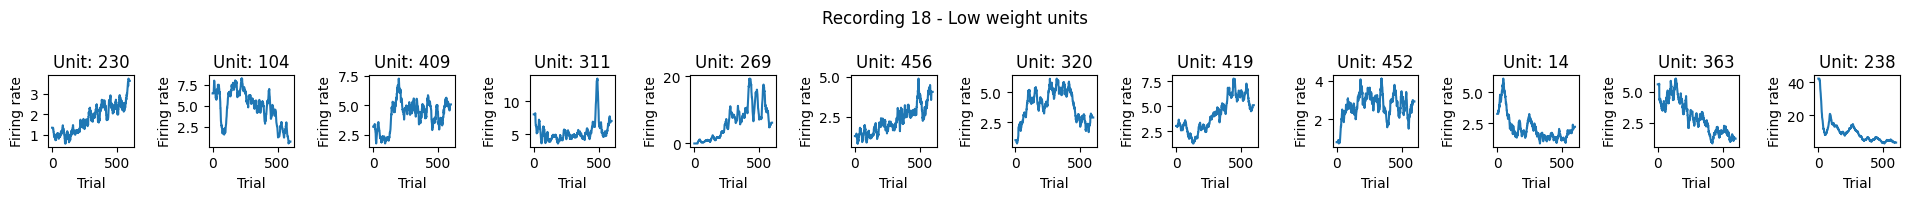

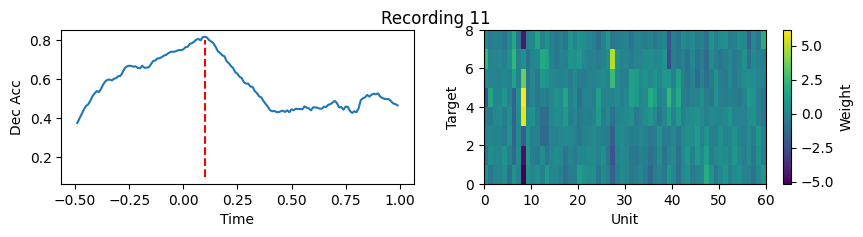

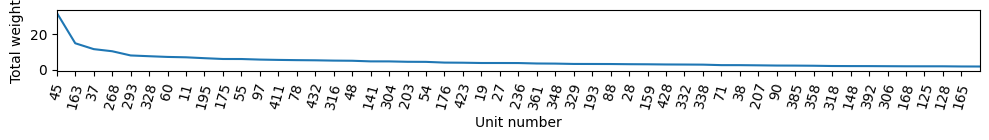

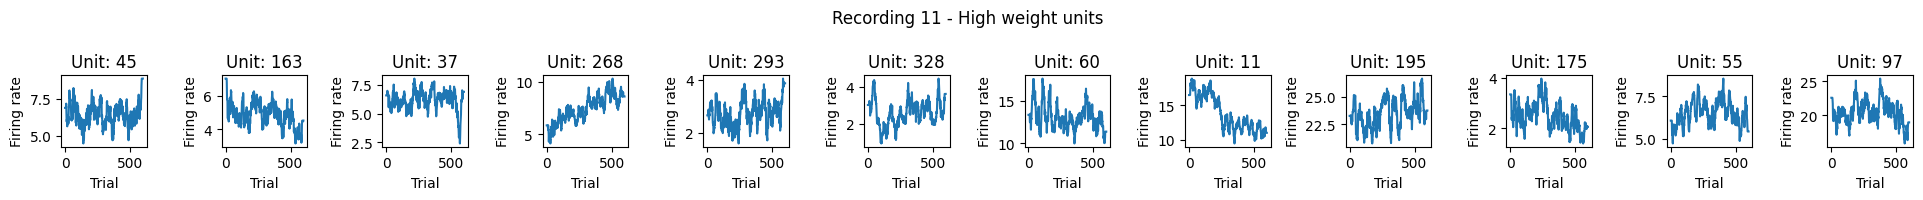

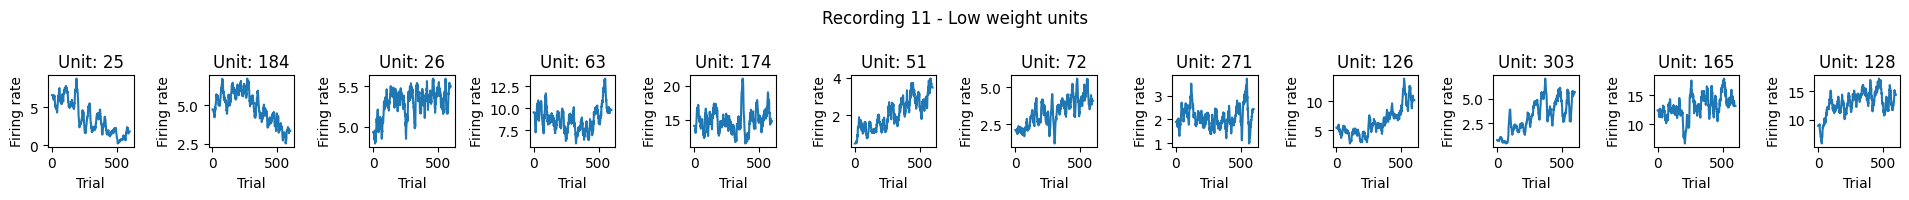

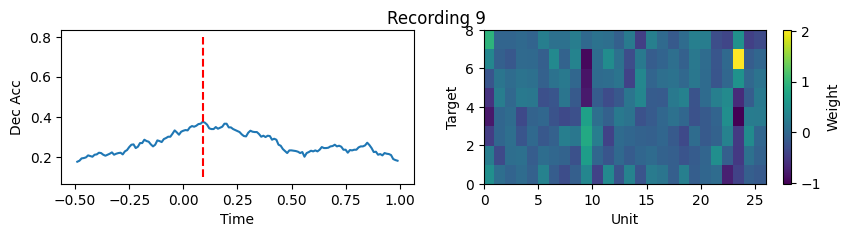

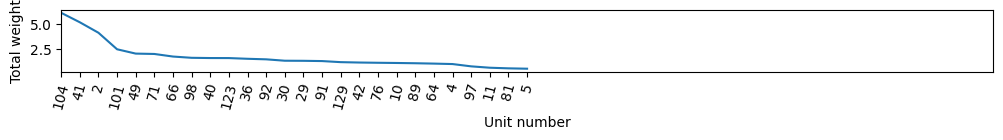

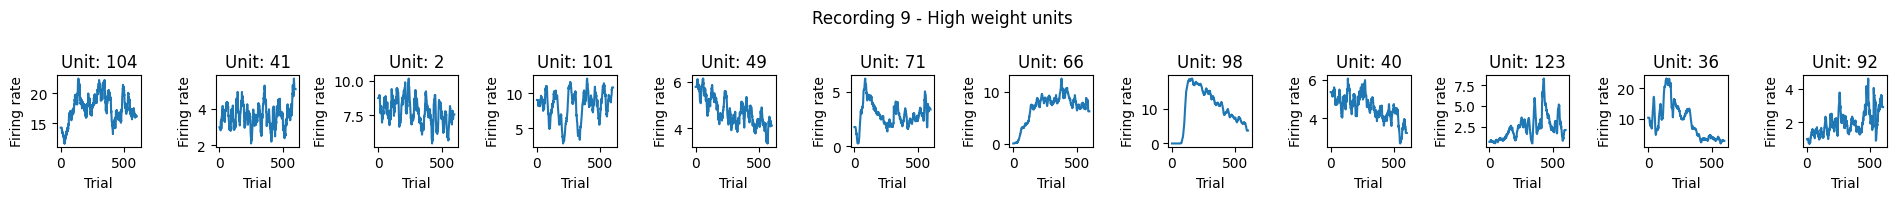

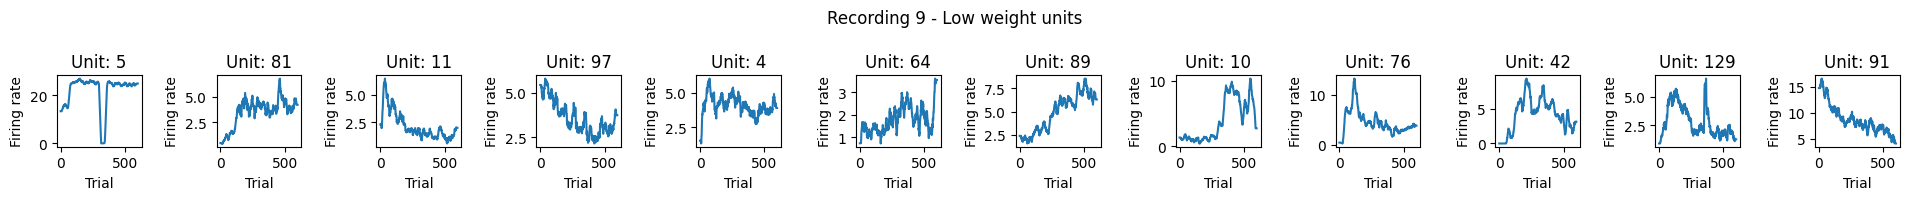

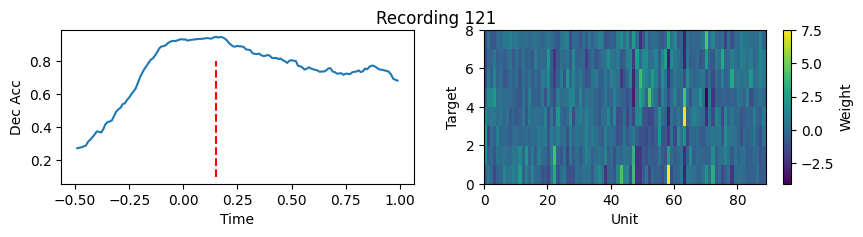

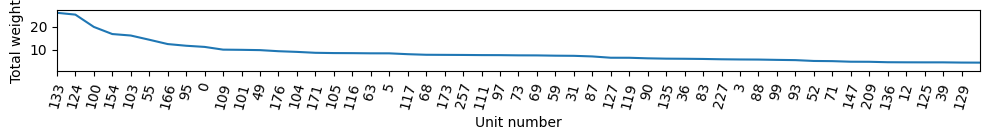

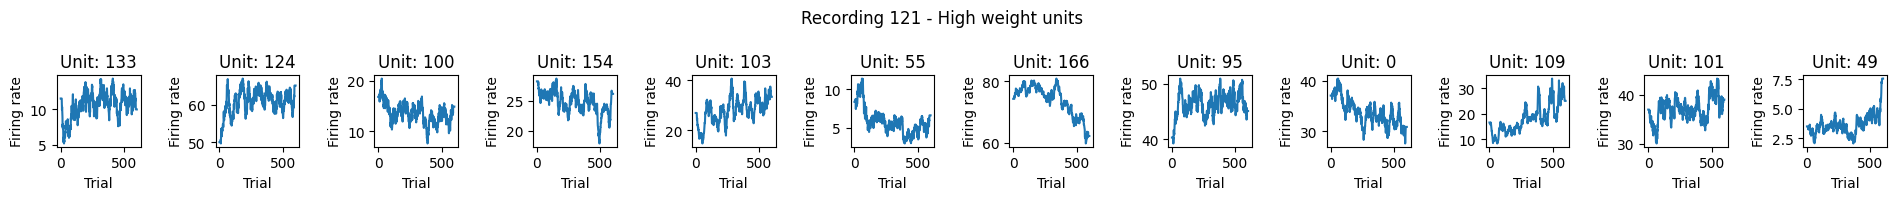

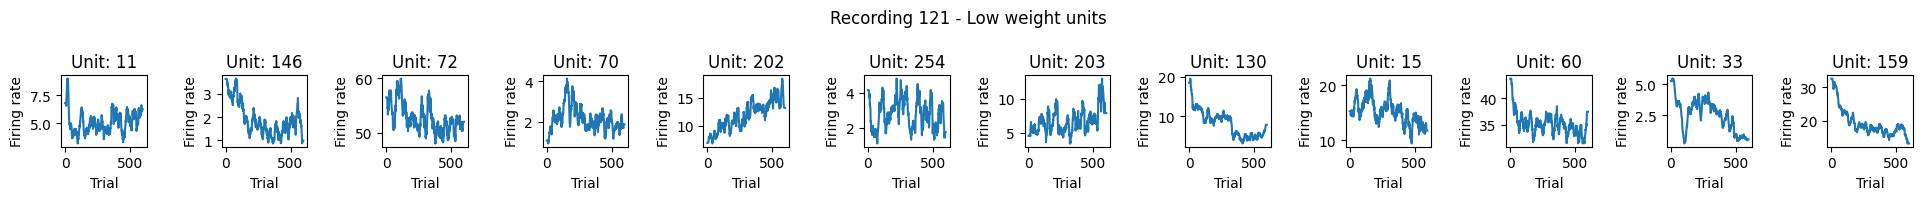

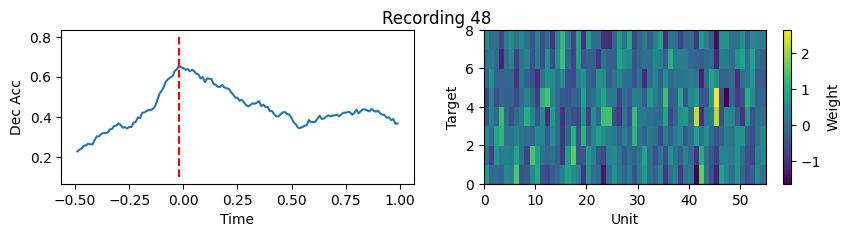

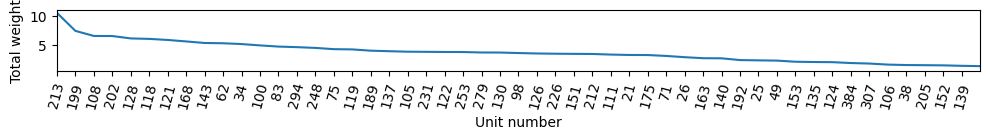

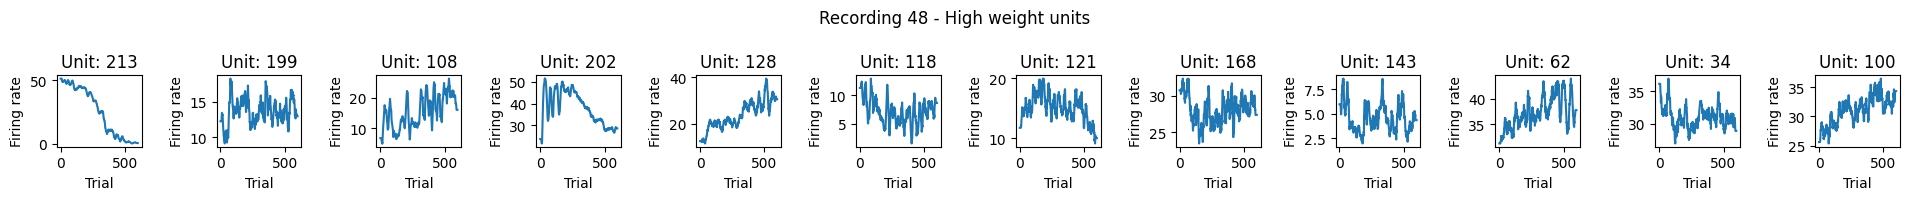

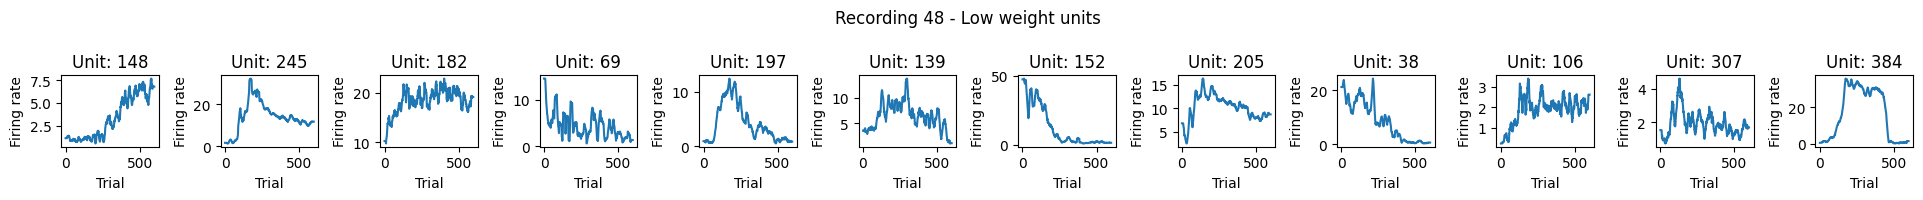

In [23]:
for irec in range(nrecs):
    fig, ax = plt.subplots(1,2,figsize=(10,2))
    ax[0].plot(np_data[align_event]['trial_time_axis'][nlda_lags:], np.mean(lda_results['scores'][irec], axis=1))

    max_tidx = np.argmax(np.mean(lda_results['scores'][irec], axis=1))
    ax[0].plot([np_data[align_event]['trial_time_axis'][nlda_lags:][max_tidx], np_data[align_event]['trial_time_axis'][nlda_lags:][max_tidx]], [0.1, 0.8], 'r--')
    # Look at weights at max t
    weightim = ax[1].pcolor(np.mean(lda_results['weights'][irec], axis=3)[max_tidx,:,:])
    ax[0].set(xlabel='Time', ylabel='Dec Acc')
    ax[1].set(xlabel='Unit', ylabel='Target')
    plt.suptitle(f"Recording {recording_site[irec]}")
    cb = plt.colorbar(weightim, label='Weight')
    
    unit_rank = np.flip(np.argsort((np.sum(np.abs(np.mean(lda_results['weights'][irec], axis=3)[max_tidx,:,:]), axis=0))))
    fig, ax = plt.subplots(1,1,figsize=(10,1.5))
    # weightim = ax[0].pcolor(np.mean(lda_results['weights'][irec], axis=3)[max_tidx,:,unit_rank].T, vmin=-10, vmax=10)
    # ax[0].set(xlabel='Unit number', ylabel='Target')
    # cb = plt.colorbar(weightim, label='Weight')
    ax.plot((np.sum(np.abs(np.mean(lda_results['weights'][irec], axis=3)[max_tidx,:,:]), axis=0))[unit_rank])
    ax.set(xlabel='Unit number', ylabel='Total weight', xlim=(0,50))
    ax.set_xticks(np.arange(len(stable_unit_idx[irec]))[:50], stable_unit_labels[irec][unit_rank][:50], rotation = 75)
    fig.tight_layout()
    plt.show()
    
    # Plot FR vs. time traces of the 10 highest weighted neurons
    avg_fr_each_trial = np.mean(np_data[align_event]['spike_align'][irec][:,:,stable_unit_idx[irec]], axis=0)
    smooth_avg_fr_each_trial = aopy.analysis.base.calc_rolling_average(avg_fr_each_trial, window_size=17)
    
    nunits_plot = 12
    fig, ax = plt.subplots(1,nunits_plot, figsize=(nunits_plot*1.6,2))
    for iunit in range(nunits_plot):
        ax[iunit].plot(smooth_avg_fr_each_trial[:ntest_trials,unit_rank[iunit]])
        ax[iunit].set(xlabel='Trial', ylabel='Firing rate', title=f"Unit: {stable_unit_labels[irec][unit_rank[iunit]]}")

    plt.suptitle(f"Recording {recording_site[irec]} - High weight units")
    fig.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(1,nunits_plot, figsize=(nunits_plot*1.6,2))
    for iunit in range(nunits_plot):
        ax[iunit].plot(smooth_avg_fr_each_trial[:ntest_trials,unit_rank[-(iunit+1)]])
        ax[iunit].set(xlabel='Trial', ylabel='Firing rate', title=f"Unit: {stable_unit_labels[irec][unit_rank[-(iunit+1)]]}")

    plt.suptitle(f"Recording {recording_site[irec]} - Low weight units")
    fig.tight_layout()
    plt.show()

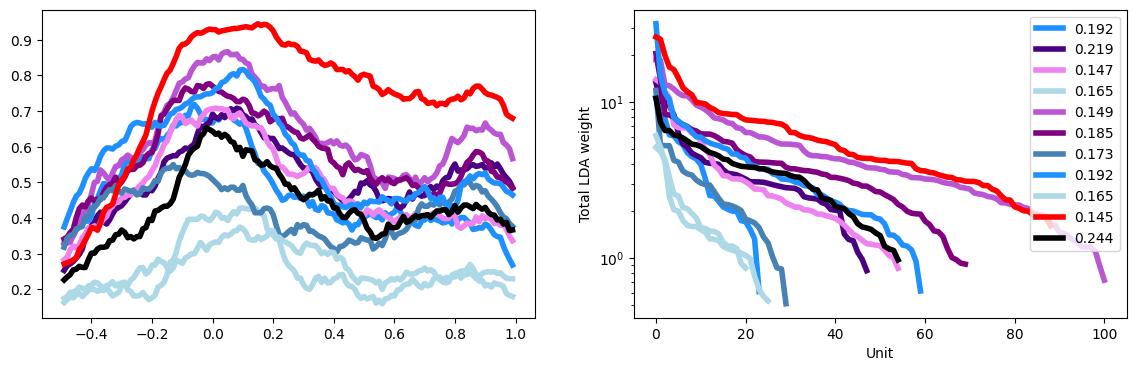

In [24]:
fig, ax = plt.subplots(1,2,figsize=(14,4))
[ax[0].plot(np_data[align_event]['trial_time_axis'][1:], np.mean(lda_results['scores'][irec],axis=1), linewidth=4,color=day_colors[irec], label=f"{np.round(ecog_dec_acc_rec_site[align_event][irec],3)}") for irec in range(nrecs)]
[ax[1].plot(lda_results['dec_unit_weight_rank'][irec], linewidth=4,color=day_colors[irec], label=f"{np.round(ecog_dec_acc_rec_site[align_event][irec],3)}") for irec in range(nrecs)]
ax[1].set(xlabel='Unit', ylabel='Total LDA weight')
ax[1].set_yscale('log')
ax[1].legend()
plt.show()

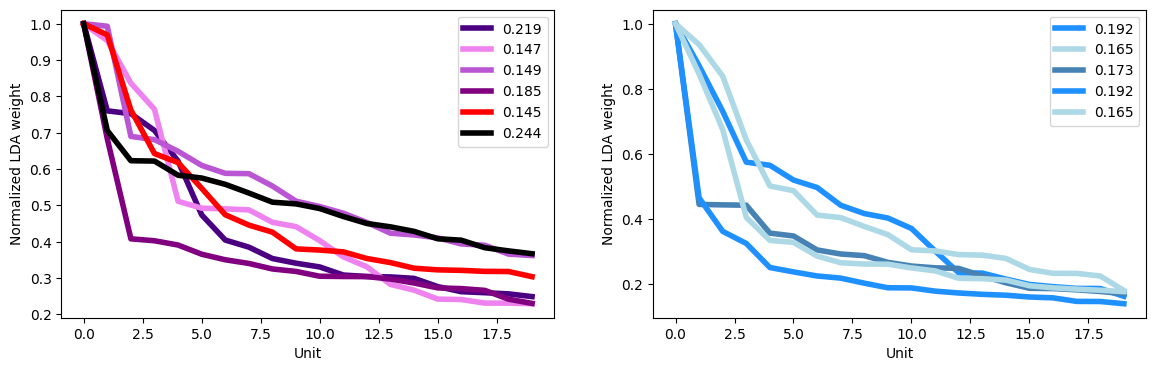

In [25]:
nunitsplt = 20
fig, ax = plt.subplots(1,2,figsize=(14,4))
[ax[0].plot(lda_results['dec_unit_weight_rank'][irec][:nunitsplt]/np.max(lda_results['dec_unit_weight_rank'][irec][:nunitsplt]), linewidth=4,color=day_colors[irec], label=f"{np.round(ecog_dec_acc_rec_site[align_event][irec],3)}") for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
[ax[1].plot(lda_results['dec_unit_weight_rank'][irec][:nunitsplt]/np.max(lda_results['dec_unit_weight_rank'][irec][:nunitsplt]), linewidth=4,color=day_colors[irec], label=f"{np.round(ecog_dec_acc_rec_site[align_event][irec],3)}") for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
[ax[iax].set(xlabel='Unit', ylabel='Normalized LDA weight') for iax in range(len(ax))]
# [ax[iax].set_yscale('log') for iax in range(len(ax))]
[ax[iax].legend() for iax in range(len(ax))]
plt.show()

### Neuron number matched

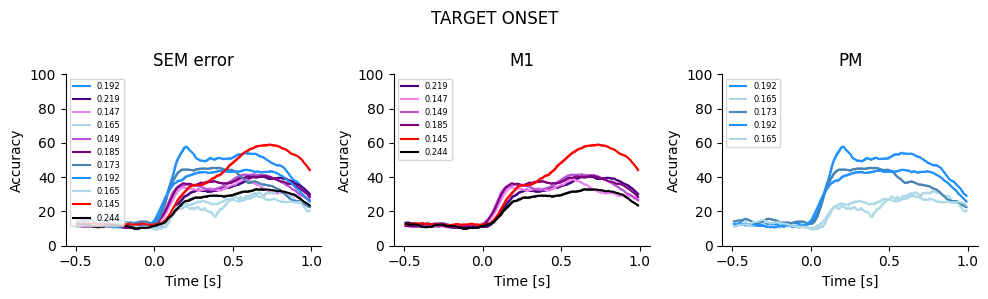

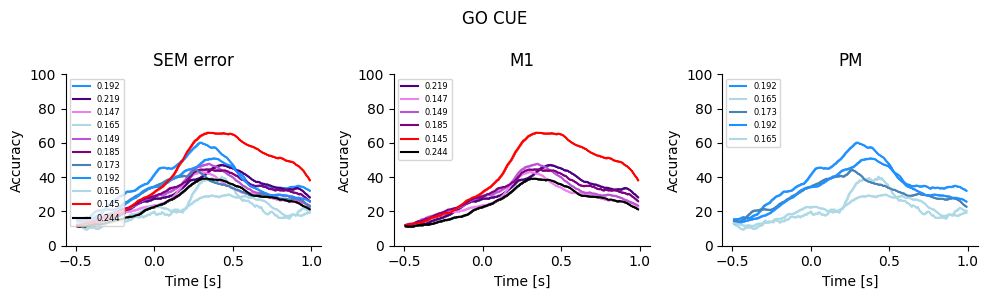

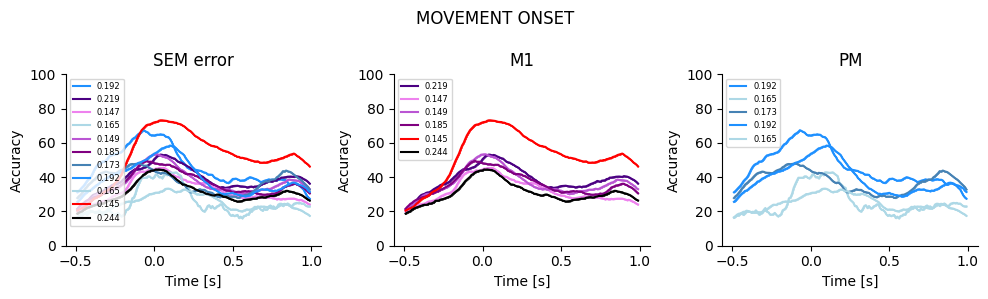

In [26]:
# Plot all recording sites overlaid
for align_event in align_events:
    fig, ax = plt.subplots(1,3,figsize=(10, 3))
    [ax[0].plot(np_data[align_event]['trial_time_axis'][nlda_lags:], 100*np.mean(lda_results[align_event]['neural_space'][irec], axis=1), color=day_colors[irec], label=f'{np.round(ecog_dec_acc_rec_site[align_event][irec],3)}') for irec in range(nrecs)]
    [ax[0].fill_between(np_data[align_event]['trial_time_axis'][nlda_lags:], 100*np.mean(lda_results[align_event]['neural_space'][irec], axis=1),100*np.mean(lda_results[align_event]['neural_space'][irec], axis=1)-aopy.analysis.calc_sem(lda_results[align_event]['neural_space'][irec], axis=1), color=day_colors[irec], alpha=0.5) for irec in range(nrecs)]
    [ax[0].fill_between(np_data[align_event]['trial_time_axis'][nlda_lags:], 100*np.mean(lda_results[align_event]['neural_space'][irec], axis=1),100*np.mean(lda_results[align_event]['neural_space'][irec], axis=1)+aopy.analysis.calc_sem(lda_results[align_event]['neural_space'][irec], axis=1), color=day_colors[irec], alpha=0.5) for irec in range(nrecs)]
    
    [ax[1].plot(np_data[align_event]['trial_time_axis'][nlda_lags:], 100*np.mean(lda_results[align_event]['neural_space'][irec], axis=1), color=day_colors[irec], label=f'{np.round(ecog_dec_acc_rec_site[align_event][irec],3)}') for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
    [ax[1].fill_between(np_data[align_event]['trial_time_axis'][nlda_lags:], 100*np.mean(lda_results[align_event]['neural_space'][irec], axis=1),100*np.mean(lda_results[align_event]['neural_space'][irec], axis=1)-aopy.analysis.calc_sem(lda_results[align_event]['neural_space'][irec], axis=1), color=day_colors[irec], alpha=0.5) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
    [ax[1].fill_between(np_data[align_event]['trial_time_axis'][nlda_lags:], 100*np.mean(lda_results[align_event]['neural_space'][irec], axis=1),100*np.mean(lda_results[align_event]['neural_space'][irec], axis=1)+aopy.analysis.calc_sem(lda_results[align_event]['neural_space'][irec], axis=1), color=day_colors[irec], alpha=0.5) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]

    [ax[2].plot(np_data[align_event]['trial_time_axis'][nlda_lags:], 100*np.mean(lda_results[align_event]['neural_space'][irec], axis=1), color=day_colors[irec], label=f'{np.round(ecog_dec_acc_rec_site[align_event][irec],3)}') for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
    [ax[2].fill_between(np_data[align_event]['trial_time_axis'][nlda_lags:], 100*np.mean(lda_results[align_event]['neural_space'][irec], axis=1),100*np.mean(lda_results[align_event]['neural_space'][irec], axis=1)-aopy.analysis.calc_sem(lda_results[align_event]['neural_space'][irec], axis=1), color=day_colors[irec], alpha=0.5) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
    [ax[2].fill_between(np_data[align_event]['trial_time_axis'][nlda_lags:], 100*np.mean(lda_results[align_event]['neural_space'][irec], axis=1),100*np.mean(lda_results[align_event]['neural_space'][irec], axis=1)+aopy.analysis.calc_sem(lda_results[align_event]['neural_space'][irec], axis=1), color=day_colors[irec], alpha=0.5) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]

    ax[0].set(xlabel='Time [s]', ylabel='Accuracy', ylim=(0,100), title='SEM error')
    ax[1].set(xlabel='Time [s]', ylabel='Accuracy', ylim=(0,100), title='M1')
    ax[2].set(xlabel='Time [s]', ylabel='Accuracy', ylim=(0,100), title='PM')
    [ax[ia].legend(loc = 'upper left', fontsize=6) for ia in range(len(ax))]
    [ax[ia].spines[['right','top']].set_visible(False) for ia in range(len(ax))]
    fig.suptitle(f"{align_event}")
    fig.tight_layout()
    # if save_figs:
    #     aopy.visualization.savefig(save_dir, 'lda_decoding_matched_pop_sem_error.svg')

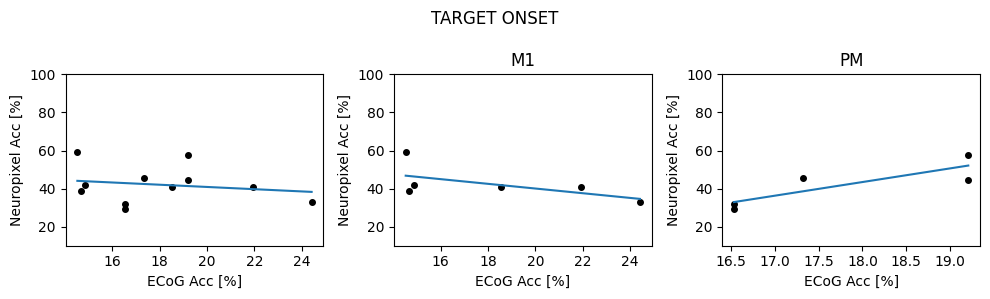

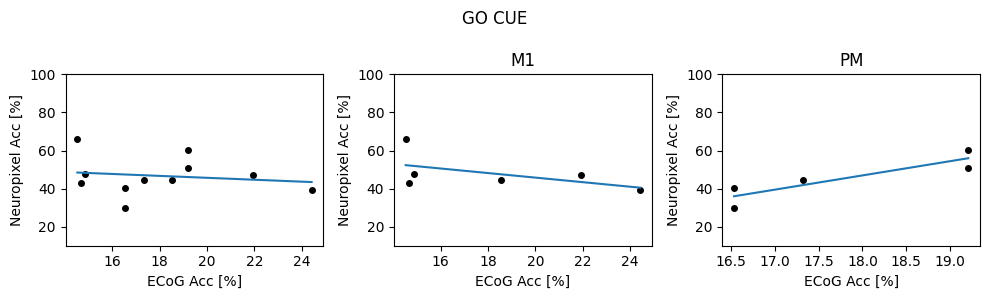

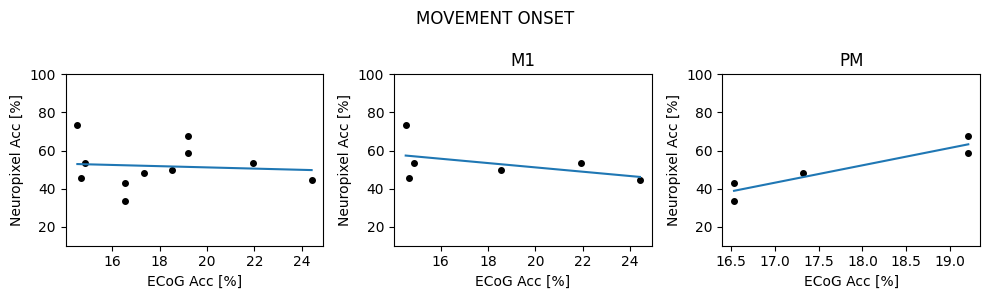

In [27]:
# Plot max decoding
for align_event in align_events:
    fig, ax = plt.subplots(1,3,figsize=(10,3))
    ax[0].plot(100*np.array(ecog_dec_acc_rec_site[align_event]), 100*np.array(lda_results[align_event]['neural_space_max']), 'k.', markersize=8)
    ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[0].set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [%]', ylim=(10, 100))
    
    ax[1].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx], 100*np.array(lda_results[align_event]['neural_space_max'])[M1_rec_idx], 'k.', markersize=8)
    ax[1].plot([100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx]), 100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx])], [(lda_results[align_event]['neural_max_reg_fit_M1'].coef_*100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx])+lda_results[align_event]['neural_max_reg_fit_M1'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit_M1'].coef_*100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx])+lda_results[align_event]['neural_max_reg_fit_M1'].intercept_)[0]])               
    ax[1].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval_M1'],3)}", (3, 20))
    ax[1].set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [%]', ylim=(10, 100), title='M1')
    
    ax[2].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx], 100*np.array(lda_results[align_event]['neural_space_max'])[PM_rec_idx], 'k.', markersize=8)
    ax[2].plot([100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx]), 100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx])], [(lda_results[align_event]['neural_max_reg_fit_PM'].coef_*100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx])+lda_results[align_event]['neural_max_reg_fit_PM'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit_PM'].coef_*100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx])+lda_results[align_event]['neural_max_reg_fit_PM'].intercept_)[0]])               
    ax[2].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval_PM'],3)}", (3, 20))
    ax[2].set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [%]', ylim=(10, 100), title='PM')
    
    fig.suptitle(f"{align_event}")
    fig.tight_layout()

### Trial adding

In [ ]:
# Plot number of stable units as a function of trials for each align_event and recording
### Move to unit quality notebook
for align_event in align_events:
    fig, ax = plt.subplots(1,3,figsize=(10,3))
    for irec in range(nrecs):
        nstable_units_temp = [len(stable_unit_idx_nunits_tradd[align_event][itradd][irec]) for itradd in range(ntrial_adding_bins)]
        ax[0].plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, nstable_units_temp, color=day_colors[irec])
        if recording_site[irec] in recording_brain_areas['M1']:
            ax[1].plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, nstable_units_temp, color=day_colors[irec])
        elif recording_site[irec] in recording_brain_areas['PM']:
            ax[2].plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, nstable_units_temp, color=day_colors[irec])
    [iax.set(xlabel='Trials', ylabel='Number of Stable Units') for iax in ax]
    plt.suptitle(f"{align_event} - Neurons active on {100*min_trial_prop}% of trials")
    fig.tight_layout()
    plt.show()

In [ ]:
for iax, align_event in enumerate(align_events):
    fig, ax = plt.subplots(1,3, figsize=(10,3))
    ax[0].plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, lda_results_tradd[align_event]['neural_max_pcc_pval'])
    ax[1].plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, lda_results_tradd[align_event]['neural_max_pcc_pval_M1'])
    ax[2].plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, lda_results_tradd[align_event]['neural_max_pcc_pval_PM'])
    
    ax[0].set(xlabel="Trials", ylabel="pvalue", title='All Recordings')
    ax[1].set(xlabel="Trials", ylabel="pvalue", title="M1")
    ax[2].set(xlabel="Trials", ylabel="pvalue", title="PM")
    
    ax0_twinx = ax[0].twinx()
    ax0_twinx.plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, np.squeeze([lda_results_tradd[align_event]['neural_max_reg_fit'][itradd].coef_ for itradd in range(ntrial_adding_bins)]), 'k')
    ax0_twinx.set(ylabel='Slope (black)')
    
    ax1_twinx = ax[1].twinx()
    ax1_twinx.plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, np.squeeze([lda_results_tradd[align_event]['neural_max_reg_fit_M1'][itradd].coef_ for itradd in range(ntrial_adding_bins)]), 'k')
    ax1_twinx.set(ylabel='Slope (black)')
    
    ax2_twinx = ax[2].twinx()
    ax2_twinx.plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, np.squeeze([lda_results_tradd[align_event]['neural_max_reg_fit_PM'][itradd].coef_ for itradd in range(ntrial_adding_bins)]), 'k')
    ax2_twinx.set(ylabel='Slope (black)')
    
    plt.suptitle(f"{align_event}")
    fig.tight_layout()
    plt.show()

### Unit adding

## Linear Regression